## Heat Eq (without discretisation)


$\mathcal{L}_{\bar{x}}^{\phi}u(\bar{x}) = \frac{\partial}{\partial t}u(\bar{x}) - \phi \frac{\partial^2}{\partial x^2}u(\bar{x}) = f(\bar{x})$, where $\bar{x} = (t, x) \in \mathbb{R}^2$

$u(x,t) = e^{-t}sin(2\pi x)$

$f(x,t) = e^{-t}(4\pi^2 - 1)sin(2\pi x)$


#### Step 1: simulate data

In [1]:
import time
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import pyGPs

In [21]:
n1 = 10
n2 = 10
np.random.seed(int(time.time()))
t_u, x_u = np.linspace(0,1,n1), np.linspace(0,1,n1)
t_f, x_f = np.linspace(0,1,n2), np.linspace(0,1,n2)

In [22]:
#y_u = 2*np.square(x_u) + np.multiply(x_u, t_u) + np.random.normal(0,1, x_u.size)
#y_f = x_f - 4*12.0 + np.random.normal(0,1, x_f.size)

y_u = np.multiply(np.exp(-t_u), np.sin(2*np.pi*x_u))
y_f = (4*np.pi**2 - 1) * np.multiply(np.exp(-t_f), np.sin(2*np.pi*x_f))

#### Step 2: evaluate kernels and covariance matrix

Declare symbols

In [23]:
x_i, x_j, t_i, t_j, sig_u, l_u, phi = sp.symbols('x_i x_j t_i t_j sig_u l_u phi')

$k_{uu}(\bar{x}_i, \bar{x}_j; \theta) = \sigma_u^2 exp(-\frac{1}{2l_u}\left[(x_i-x_j)^2 +(t_i-t_j)^2\right])$

In [24]:
k_uu_sym = sig_u**2*sp.exp(-1/(2*l_u)*((x_i - x_j)**2 + (t_i - t_j)**2))
k_uu_fn = sp.lambdify((x_i, x_j, t_i, t_j, sig_u, l_u), k_uu_sym, "numpy")
def kuu(t, x, sigma, l):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = k_uu_fn(x[i], x[j], t[i], t[j], sigma, l)
    return k

$k_{ff}(\bar{x}_i,\bar{x}_j;\theta,\phi) \\
= \mathcal{L}_{\bar{x}_i}^\phi \mathcal{L}_{\bar{x}_j}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) \\
= \mathcal{L}_{\bar{x}_i}^\phi \left[ \frac{\partial}{\partial t_j}k_{uu} - \phi \frac{\partial^2}{\partial x_j^2} k_{uu} \right] \\
= \frac{\partial}{\partial t_i}\frac{\partial}{\partial t_j}k_{uu} - \phi \left[ \frac{\partial}{\partial t_i}\frac{\partial^2}{\partial x_j^2}k_{uu} + \frac{\partial^2}{\partial x_i^2}\frac{\partial}{\partial t_j}k_{uu} \right] + \phi^2 \frac{\partial^2}{\partial x_i^2}\frac{\partial^2}{\partial x_j^2}k_{uu}$

In [25]:
k_ff_sym = sp.diff(k_uu_sym, t_j, t_i) \
        - phi*sp.diff(k_uu_sym,x_j,x_j,t_i) \
        - phi*sp.diff(k_uu_sym,t_j,x_i,x_i) \
        + phi**2*sp.diff(k_uu_sym,x_j,x_j,x_i,x_i)
k_ff_fn = sp.lambdify((x_i, x_j, t_i, t_j, sig_u, l_u, phi), k_ff_sym, "numpy")
def kff(t, x, sigma, l, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = k_ff_fn(x[i], x[j], t[i], t[j], sigma, l, p)
    return k

$k_{fu}(\bar{x}_i,\bar{x}_j;\theta,\phi) \\
= \mathcal{L}_{\bar{x}_i}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) \\
= \frac{\partial}{\partial t_i}k_{uu} - \phi \frac{\partial^2}{\partial x_i^2}k_{uu}$

In [26]:
k_fu_sym = sp.diff(k_uu_sym,t_i) - phi*sp.diff(k_uu_sym,x_i,x_i)
k_fu_fn = sp.lambdify((x_i, x_j, t_i, t_j, sig_u, l_u, phi), k_fu_sym, "numpy")
def kfu(t1, x1, t2, x2, sigma, l, p):
    k = np.zeros((t1.size, t2.size))
    for i in range(t1.size):
        for j in range(t2.size):
            k[i,j] = k_fu_fn(x1[i], x2[j], t1[i], t2[j], sigma, l, p)
    return k

In [27]:
k_uf_sym = sp.diff(k_uu_sym,t_j) - phi*sp.diff(k_uu_sym,x_j,x_j)
k_uf_fn = sp.lambdify((x_i, x_j, t_i, t_j, sig_u, l_u, phi), k_uf_sym, "numpy")
def kuf(t1, x1, t2, x2, sigma, l, p):
    k = np.zeros((t2.size, t1.size))
    for i in range(t2.size):
        for j in range(t1.size):
            k[i,j] = k_uf_fn(x2[i], x1[j], t2[i], t1[j], sigma, l, p)
    return k

#### Step 3: create covariance matrix and NLML

```
params = [sig_u, l_u, phi]
```

In [28]:
def nlml(params, t1, x1, y1, t2, x2, y2, s):
    K = np.block([
        [
            kuu(t1, x1, params[0], params[1]) + s*np.identity(x1.size),
            kuf(t1, x1, t2, x2, params[0], params[1], params[2])
        ],
        [
            kfu(t1, x1, t2, x2, params[0], params[1], params[2]),
            kff(t2, x2, params[0], params[1], params[2]) + s*np.identity(x2.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [29]:
nlml((1,1,1), t_u, x_u, y_u, t_f, x_f, y_f, 1e-6)

71392.05022816178

In [31]:
minimize(nlml, np.random.rand(3), args=(t_u, x_u, y_u, t_f, x_f, y_f, 1e-6), method="Nelder-Mead", options={'maxiter' : 5000})

KeyboardInterrupt: 

### Using pyGPs

In [12]:
model_u = pyGPs.GPR()
model_u.setData(np.matrix([t_u, x_u]).T, y_u)
model_u.optimize(np.matrix([t_u, x_u]).T, y_u)

model_f = pyGPs.GPR()
model_f.setData(np.matrix([t_f, x_f]).T, y_f)
model_f.optimize(np.matrix([t_f, x_f]).T, y_f)


Number of line searches 23
Number of line searches 40


### Using GPy

In [13]:
import GPy

In [14]:
kernel = GPy.kern.RBF(input_dim=2)
kernel

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


In [15]:
m = GPy.models.GPRegression(np.matrix([t_u, x_u]).T, y_u.reshape(y_u.size,1),kernel)

In [16]:
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


 /usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


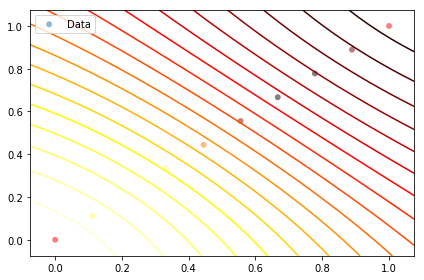

In [17]:
fig = m.plot()
display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))

In [18]:
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   3.023154e+01   1.036336e+03 
    00s03  0013   2.871205e+00   9.439965e+00 
    00s08  0034  -1.823972e+01   1.193142e+00 
    00s08  0035  -1.824231e+01   7.535538e-02 
    00s13  0052  -1.824332e+01   5.300550e-06 
    00s14  0059  -1.824332e+01   4.404495e-12 
Runtime:     00s14
Optimization status: Converged



In [19]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -18.243322729423912
Optimization restart 2/10, f = -18.24331851568477
Optimization restart 3/10, f = -18.243282947233105
Optimization restart 4/10, f = -18.243322448955034
Optimization restart 5/10, f = -18.243320609390274
Optimization restart 6/10, f = -18.243322611737554
Optimization restart 7/10, f = -18.24326486247635
Optimization restart 8/10, f = -18.243322613337867
Optimization restart 9/10, f = -18.243320195882394
Optimization restart 10/10, f = -18.243322538533803


GP_regression.,value,constraints,priors
rbf.variance,1.4272866231917112,+ve,
rbf.lengthscale,0.5474649810661156,+ve,
Gaussian_noise.variance,8.244775691669632e-16,+ve,


 /usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


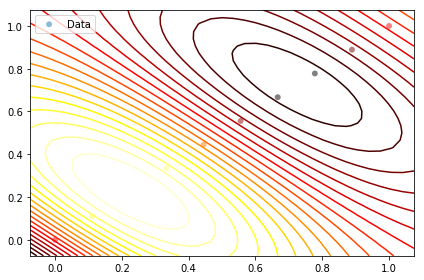

In [20]:
display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')